In [1]:
#!pip install scikit-learn
#!pip install pytesseract
#!pip install tesseract
#!pip install tesseract-ocr this command deosnt weork

#So install tesseract-ocr using apt install

In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

import pytesseract

### Part 1: Extract license plate from sample image

In [2]:
def get_image_formats(img):

    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(img, alpha=(255.0))

    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)

    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    
    return plate_image, gray, blur, binary, dilate

In [3]:
def plot_allimages(allimage_types, allimage_titles, string_flag = True):
    tess_config = "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"

    plt.figure(num = 1, figsize= (20,10))
    for img_cnt, img in enumerate(allimage_types):
        plt.subplot(2,3,img_cnt+1)
        plt.imshow(img, cmap="gray")
        
        if (string_flag ==True):
            out = pytesseract.image_to_string(img, config=tess_config, lang="eng")
        else:
            out =''
            
        plt.title(allimage_titles[img_cnt] + ' : ' + out)            

        #print(f'Image: {out}')   

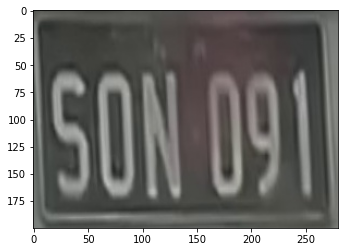

In [4]:
#LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/BMW/BMW_red_front_short/det_LpImg_crops/0_0_1_0_N.jpg']

LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/Dash_cam_4/det_LpImg_crops/highres_plate_0_0_0_N.jpg']
#LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/Dash_cam_4/det_LpImg_crops/2_0_1_0_NC40SN.jpg']

img_list = []
for Img in  LpImg_paths:
    img = cv2.imread(Img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    img_list.append(img)
    
plt.imshow(img_list[0])

LpImg = img_list

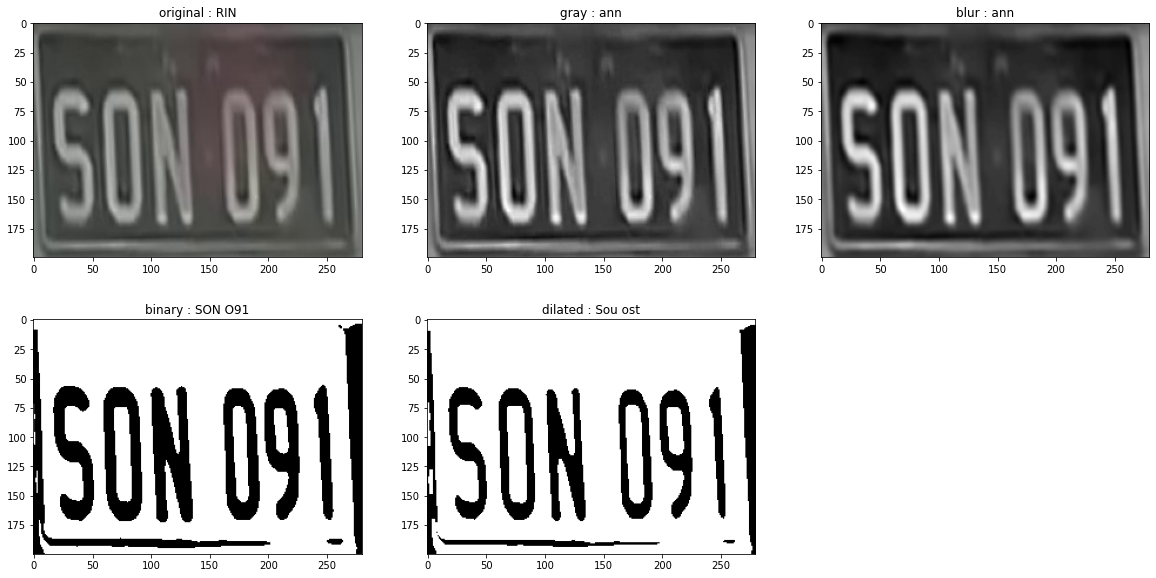

In [5]:
plate_image, gray, blur, binary, dilate = get_image_formats(LpImg[0])
allimage_types = [plate_image, gray, blur, binary, dilate]
allimage_titles = ['original', 'gray', 'blur', 'binary', 'dilated']

plot_allimages(allimage_types, allimage_titles, string_flag = True)

## Part 2: Segementing license characters

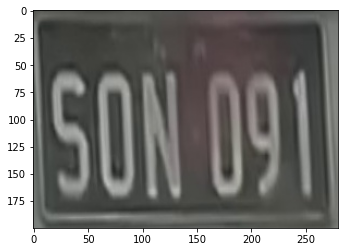

In [23]:
#LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/BMW/BMW_red_front_short/det_LpImg_crops/0_0_1_0_N.jpg']

LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/Dash_cam_4/det_LpImg_crops/highres_plate_0_0_0_N.jpg']
#LpImg_paths = ['../../TSK_00_MSC/wt2-body-tracker/output/Dash_cam_4/det_LpImg_crops/highres_plate_0_2_0_NC40SN.jpg']

img_list = []
for Img in  LpImg_paths:
    img = cv2.imread(Img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    img_list.append(img)
    
plt.imshow(img_list[0])

LpImg = img_list

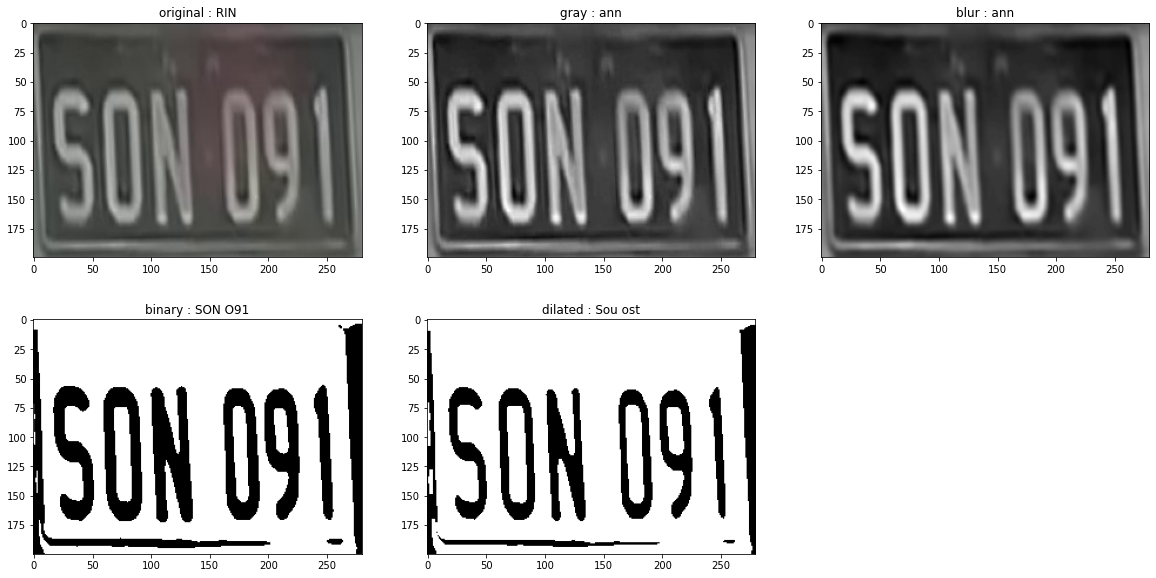

In [24]:
plate_image, gray, blur, binary, dilate = get_image_formats(LpImg[0])
allimage_types = [plate_image, gray, blur, binary, dilate]
allimage_titles = ['original', 'gray', 'blur', 'binary', 'dilated']

plot_allimages(allimage_types, allimage_titles, string_flag = True)

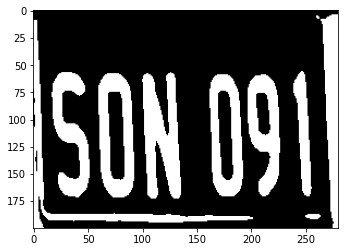

In [25]:
inverted_binary = binary.copy()
inverted_binary[inverted_binary ==0] = 1
inverted_binary[inverted_binary ==255] = 0
inverted_binary[inverted_binary ==1] = 255

plt.figure(num = 1)
plt.imshow(inverted_binary, cmap="gray")


In [26]:
tess_config = "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"

out = pytesseract.image_to_string(binary, config=tess_config, lang="eng")
print(f'Text to string output : Binary Image : {out}')
out = pytesseract.image_to_string(inverted_binary, config=tess_config, lang="eng")
print(f'Text to string output : Inverted Binary Image : {out}')

Text to string output : Binary Image : SON O91
Text to string output : Inverted Binary Image : AN


In [27]:
def img_bg_detector_hor(input_img):    
    img = input_img.copy()
    img[img == high_color] = 1
    max_cnts_list = []
    for rr in range(img.shape[0]):       
        max_cnts = [0,0]
        cnts = [0,0]    
        
        prev = img[rr,0]
        
        for cc in range(1,img.shape[1]):
            pix = img[rr,cc]
            
            if (pix != prev):
                if (max_cnts[prev]<cnts[prev]):
                    max_cnts[prev] = cnts[prev]
                cnts[prev] = 0
                
            cnts[pix]= cnts[pix]+1
            #print([prev, pix, cnts, max_cnts])
            prev = pix
        
        if (max_cnts[prev]<cnts[prev]):
            max_cnts[prev] = cnts[prev]   
        #print('End of line')
        #print([cnts, max_cnts])    
        max_cnts_list.append(max_cnts)
        
    return max_cnts_list

In [28]:
def img_bg_detector_ver(input_img):    
    img = input_img.copy()
    img[img == high_color] = 1

    max_cnts_list = []
    for cc in range(img.shape[1]):       
        max_cnts = [0,0]
        cnts = [0,0]    
        
        prev = img[0,cc]
        
        for rr in range(1,img.shape[0]):
            
            pix = img[rr,cc]
            
            if (pix != prev):
                if (max_cnts[prev]<cnts[prev]):
                    max_cnts[prev] = cnts[prev]
                cnts[prev] = 0
                
            cnts[pix]= cnts[pix]+1
            #print([rr,cc ,prev, pix, cnts, max_cnts])
            prev = pix
        
        if (max_cnts[prev]<cnts[prev]):
            max_cnts[prev] = cnts[prev]   
        #print('End of line')
        #print([cnts, max_cnts])    
        max_cnts_list.append(max_cnts)
        #print(max_cnts_list)
        
    return max_cnts_list

In [29]:
def swap_image_colors(img):
    swap_img = img.copy()
    swap_img[swap_img==low_color] = 100
    swap_img[swap_img==high_color] = low_color
    swap_img[swap_img==100] = high_color    
    return swap_img
    

In [32]:
print(binary[0])

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

In [33]:
print(swap_binary[0])

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

[9, 155]


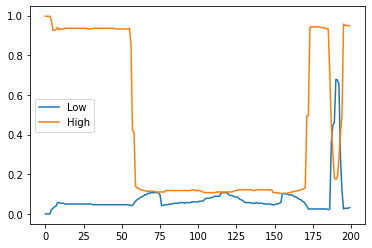

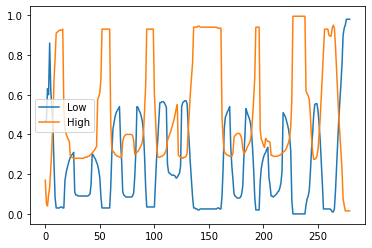

In [34]:
def count_above_thres(cnt_list, thres):
    cnt_array = []
    for x in cnt_list:
        if x>thres:
            cnt_array.append(1)
    return sum(cnt_array)

thres = 0.7
low_color = 0
high_color = 255

[h,w] = binary.shape

max_list = img_bg_detector_hor(binary)

cnt_low_list_hor = [xy[0]/w for xy in max_list]
cnt_high_list_hor = [xy[1]/w for xy in max_list]

plt.figure(1)
plt.plot(cnt_low_list_hor)
plt.plot(cnt_high_list_hor)
plt.legend(['Low','High'])

[h,w] = binary.shape

max_list_ver = img_bg_detector_ver(binary)

cnt_low_list_ver = [xy[0]/h for xy in max_list_ver]
cnt_high_list_ver = [xy[1]/h for xy in max_list_ver]

plt.figure(2)
plt.plot(cnt_low_list_ver)
plt.plot(cnt_high_list_ver)
plt.legend(['Low','High'])


low_cnt = count_above_thres(cnt_low_list_hor, thres) + count_above_thres(cnt_low_list_ver, thres)
high_cnt = count_above_thres(cnt_high_list_hor, thres) + count_above_thres(cnt_high_list_ver, thres)

print([low_cnt,high_cnt])

if (low_cnt > high_cnt):
    swap_binary = swap_image_colors(binary)
else:
    bgcolor = high_color

In [35]:
#print(binary[0])

In [36]:
#

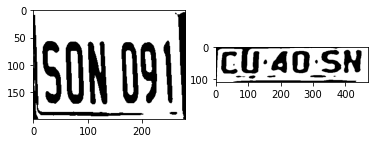

In [37]:
plt.figure(num=1)
plt.subplot(121)
plt.imshow(binary,cmap="gray")
plt.subplot(122)
plt.imshow(swap_binary,cmap="gray")

In [21]:
out = pytesseract.image_to_string(swap_binary, config=tess_config, lang="eng")
print(f'Text to string output : Inverted Binary Image : {out}')

Text to string output : Inverted Binary Image : cU-40°SN


[0, 0, 417, 96]
[16, 17, 50, 68]
[53, 103, 378, 7]
[53, 54, 4, 6]
[61, 91, 29, 5]
[101, 90, 20, 10]
[146, 41, 11, 15]
[157, 89, 26, 7]
[170, 16, 50, 66]
[235, 15, 53, 68]
[290, 89, 48, 7]
[304, 42, 9, 12]
[324, 12, 61, 70]
[361, 91, 8, 3]
[393, 12, 54, 70]


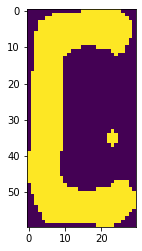

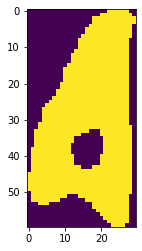

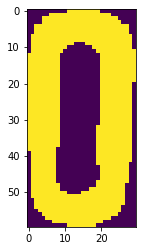

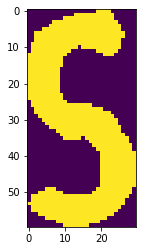

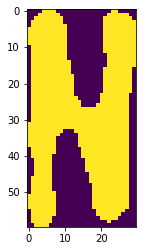

In [34]:
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
digit_w = 30
digit_h = 60

crop_characters = []
#print(cont[0])
for c in sort_contours(cont):
    #print('************************************')
                #print('Inside character recognition')
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    
    print([x,y,w,h])
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/binary.shape[0]>=0.5:

            curr_num = binary[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))

            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            plt.figure()
            plt.imshow(curr_num)

